# Model AOPs

First attempt at modeling AOPs.  For not will now use hill curves because the data is very noisy and don't know how
to assess goodness-of-fit.

Instead a simple approach could be done as follows

1) get chemical response data for target
2) use curveP to correct noise and establish monotonicity
3) put all concentrations on same scale

Imports...

In [1]:
import pandas as pd
import config
import seaborn as sns
import numpy as np
from curvep import curveP, CONCLIST
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau


sns.set(style="ticks", context="talk")
plt.style.use("dark_background")



### Get data

First get all the AIDs associated with a set of targets.

This part can be modified once its decided how assays will be grouped.  E.g, here ESR1, ESR2 will represent two different AOPs, pathways, etc.

In [2]:
# get AIDs associated with target
TARGETS = ['ESR1', 'TP53']
TARGETS_STR_LIST = ["\'" + t + "\'" for t in TARGETS]
TARGETS_STR = ", ".join(map(str, TARGETS_STR_LIST))
targets_array = f'({TARGETS_STR})'

# get assays that belong to a particular
# target
query = 'SELECT tG.PUBCHEM_AID, tG.GeneSymbol ' \
        'FROM targets tG ' \
        'WHERE GeneSymbol in {}' \
        ''.format(targets_array)

genes_aids = pd.read_sql_query(query, con=config.Config.DB_URI)

# get active compounds in AIDS

aid_list = [str(aid)for aid in genes_aids.PUBCHEM_AID]

aid_string = ", ".join(map(str, aid_list))
aid_query = f'({aid_string})'

actives_query = 'SELECT c.PUBCHEM_CID as CID, c.PUBCHEM_AID as AID, c.PUBCHEM_SID as SID ' \
                'FROM concise c ' \
                'WHERE c.PUBCHEM_AID in {} AND c.PUBCHEM_ACTIVITY_OUTCOME == "Active" AND ' \
                'c.PUBCHEM_CID is not null AND c.PUBCHEM_SID is not null'.format(aid_query)

active_cmps = pd.read_sql_query(actives_query, con=config.Config.DB_URI)
active_cmps['SID'] = active_cmps['SID'].astype(int)

sid_list = [str(sid)for sid in active_cmps.SID]

sid_string = ", ".join(map(str, sid_list))
sid_query = f'({sid_string})'

hill_params_query = 'SELECT  SID, AID, AC50, TOP, SLOPE, MSE ' \
                'FROM hill_models ' \
                'WHERE AID in {} AND SID in {} '.format(aid_query, sid_query)

hill_params = pd.read_sql_query(hill_params_query, con=config.Config.DB_URI)

# this merge is necessary because
# the former query gathers all data
# for all sid and aid that have any active cmps
# not just the pairs of active sid, aid
# could be solved by a SQLite join, but
# right now takes too long
hill_merged = pd.merge(hill_params, active_cmps[['SID', 'CID', 'AID']].drop_duplicates(['SID', 'CID', 'AID']), on=['SID', 'AID'])
print(hill_merged.head())



      SID     AID       AC50           TOP     SLOPE           MSE      CID
0  842140  624305   9.689973  8.958368e+01  8.000000  1.184871e+02   644396
1  842142     713   1.000000 -1.000000e-10  1.000000  6.773778e+02  5770444
2  842204     902  37.520229 -1.199427e+02  8.000000  3.052045e-07   644459
3  842204     924  41.108763 -1.191685e+02  7.997274  7.044253e-08   644459
4  842291     902   9.798590 -6.304339e+01  7.975594  1.781409e-09   644550


In [6]:
for t, data in genes_aids.groupby('GeneSymbol'):
    print(data.PUBCHEM_AID.nunique(), t)

13 ESR1
8 TP53


Now, create an example model just using one compound....

This can be extended to create models for $n$ compounds when ready...

In [3]:
hill_merged.query("CID == 73864")

,SID,AID,AC50,TOP,SLOPE,MSE,CID
4835,26757531,588513,0.011761,-3.887146e+01,0.300000,163.535144,73864
4836,26757531,588514,0.502084,4.824680e+01,2.213343,102.268508,73864
6747,144208665,651631,57.295229,-1.084922e+02,8.000000,1.739599,73864
6748,144208665,743075,1.865656,1.780010e+01,7.999998,26.757873,73864
6749,144208665,743079,35.687261,-3.497626e-11,7.527904,2310.394639,73864
6750,144208665,1259383,3.962134,6.988889e+01,2.220204,1.785847,73864
8734,144213946,651631,57.295229,-1.084922e+02,8.000000,1.739599,73864
8735,144213946,743069,36.132914,-5.458658e+01,8.000000,0.000123,73864
8736,144213946,743075,8.977333,1.287930e+01,8.000000,16.953790,73864
8737,144213946,743079,2.311193,6.878584e+01,7.999993,406.643461,73864


In [13]:
counts = hill_merged.groupby('CID')['AID'].nunique().sort_values()

scaled_data_corrected = hill_merged.merge(genes_aids.rename(columns={'PUBCHEM_AID': 'AID', 'GeneSymbol': 'Target'}))

example_cid = 73864
example_cid = 2733526

training_data = scaled_data_corrected.query(f"CID == {example_cid}")
training_data = scaled_data_corrected.copy().dropna()

In [14]:
xs = np.asarray(CONCLIST)
np.log10(xs)[-1]

2.0

Format data

In [15]:
from curve_fitting import hill_curve
xs = np.asarray(CONCLIST)

dfs = []

for (aid, cid), params in training_data.groupby(['AID', 'CID']):

    params = params[params.MSE == params.MSE.min()]

    if params.shape[0] > 1:
        print(params)
    curve = hill_curve(xs, params.AC50.iloc[0], params.TOP.iloc[0], params.SLOPE.iloc[0])
    df = pd.DataFrame()
    df['log(Concentration)'] = np.log10(xs)
    df['Response'] = curve
    df['AID'] = aid
    df['CID'] = cid
    df['Target'] = params.Target.iloc[0]
    dfs.append(df)

            SID     AID       AC50         TOP  SLOPE       MSE    CID Target
7803  144208665  651631  57.295229 -108.492219    8.0  1.739599  73864   TP53
8050  144213946  651631  57.295229 -108.492219    8.0  1.739599  73864   TP53
            SID     AID  AC50           TOP  SLOPE           MSE  CID Target
5274  144208790  743075   1.0  1.000000e-10    1.0  3.101687e-21  299   ESR1
5363  144210418  743075   1.0  1.000000e-10    1.0  3.101687e-21  299   ESR1
            SID     AID  AC50           TOP  SLOPE           MSE  CID Target
5391  144210941  743075   1.0  1.000000e-10    1.0  3.101687e-21  727   ESR1
5492  144213242  743075   1.0  1.000000e-10    1.0  3.101687e-21  727   ESR1
            SID     AID  AC50           TOP  SLOPE           MSE   CID Target
5334  144209614  743075   1.0  1.000000e-10    1.0  3.101687e-21  7031   ESR1
5370  144210599  743075   1.0  1.000000e-10    1.0  3.101687e-21  7031   ESR1
            SID     AID  AC50           TOP  SLOPE           MSE    CI

In [16]:
dfs


[    log(Concentration)      Response  AID   CID Target
 0            -6.000000 -9.999990e-17  713  2406   ESR1
 1            -5.571924 -2.679629e-16  713  2406   ESR1
 2            -5.395833 -4.019439e-16  713  2406   ESR1
 3            -5.219742 -6.029146e-16  713  2406   ESR1
 4            -5.043650 -9.043691e-16  713  2406   ESR1
 5            -4.867559 -1.356548e-15  713  2406   ESR1
 6            -4.691468 -2.034808e-15  713  2406   ESR1
 7            -4.515377 -3.052180e-15  713  2406   ESR1
 8            -4.339285 -4.578200e-15  713  2406   ESR1
 9            -4.163194 -6.867143e-15  713  2406   ESR1
 10           -3.987103 -1.030036e-14  713  2406   ESR1
 11           -3.811012 -1.544974e-14  713  2406   ESR1
 12           -3.634920 -2.317283e-14  713  2406   ESR1
 13           -3.458829 -3.475522e-14  713  2406   ESR1
 14           -3.282738 -5.212377e-14  713  2406   ESR1
 15           -3.106646 -7.816528e-14  713  2406   ESR1
 16           -2.930555 -1.172021e-13  713  2406

In [17]:
training_data.CID.nunique()

5064

In [18]:
dfs = pd.concat(dfs)


,log(Concentration),Response,AID,CID,Target
0,-6.000000,-9.999990e-17,713,2406,ESR1
1,-5.571924,-2.679629e-16,713,2406,ESR1
2,-5.395833,-4.019439e-16,713,2406,ESR1
3,-5.219742,-6.029146e-16,713,2406,ESR1
4,-5.043650,-9.043691e-16,713,2406,ESR1
...,...,...,...,...,...
40,1.295635,8.230740e+01,1259383,54685925,ESR1
41,1.471726,8.330106e+01,1259383,54685925,ESR1
42,1.647817,8.379616e+01,1259383,54685925,ESR1
43,1.823909,8.404062e+01,1259383,54685925,ESR1


In [19]:
dfs.CID.nunique()

5064

In [21]:
# create the F matrix

F_matrix = pd.DataFrame(index=genes_aids.PUBCHEM_AID.unique().astype(int), columns=genes_aids.GeneSymbol.unique())

for aop, aop_data in genes_aids.groupby('GeneSymbol'):
    for aid in aop_data.PUBCHEM_AID.unique():
        F_matrix.loc[aid, aop] = 1
F_matrix = F_matrix.fillna(0)
F_matrix


,ESR1,TP53
713,1,0
737,1,0
1078,1,0
1079,1,0
1223,1,0
588513,1,0
588514,1,0
743069,1,0
743075,1,0
743079,1,0


In [23]:
frames = {}
cids = []


for cid, d in dfs.groupby('CID'):
    training_wide = d.pivot(columns='log(Concentration)', index='AID', values='Response')
    # fill missing data AIDs
    training_wide = training_wide.reindex(F_matrix.index).fillna(0)
    frames[cid] = training_wide
    cids.append(cid)

In [24]:
cr_responses = np.stack([frames[cas].values for cas in cids], axis=2)

In [25]:
cr_responses.shape

(21, 45, 5064)

In [27]:

EPOCHS = 750
STEPS = 100
INITIAL_LR = 1
GAMMA = 0.5

F = torch.tensor(F_matrix.values, dtype=torch.float)
R = torch.tensor(np.random.random(size=(F.shape[1], cr_responses.shape[1], cr_responses.shape[2])),
                 dtype=torch.float, requires_grad=True)

# R = torch.tensor(torch.clamp(R, min=0, max=1), requires_grad=True)


y = torch.tensor(cr_responses)

optimizer = optim.Adam([R], lr=INITIAL_LR)
#scheduler = StepLR(optimizer, step_size=STEPS, gamma=0.9)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=50)

In [28]:
losses = np.array([])

for epoch in range(EPOCHS):
    # model is y = FR
    optimizer.zero_grad()
    #R = torch.clamp(R, min=0, max=1)
    model = torch.tensordot(F, R, dims=([1], [0]))


    ss_term = torch.mean(torch.square(model - y))

    x = torch.sum(R)
    penalty_term = x ** 10 / (x ** 10 + 0.5 ** 10)

    loss = ss_term + penalty_term
    loss = ss_term

    loss.backward()
    optimizer.step()
    losses = np.append(losses, loss.detach().numpy())
#     if losses[-50:].var() < 0.1 and epoch>10:
#         #print("Reducing LR...")
#         for g in optimizer.param_groups:
#             g['lr'] = g['lr']*GAMMA
    scheduler.step(loss)
    if epoch % STEPS == 0:
        print(loss)
        print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))

tensor(62.9721, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-0 lr: 1
tensor(49.7599, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-100 lr: 1
tensor(49.7596, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-200 lr: 0.010000000000000002
tensor(49.7596, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-300 lr: 0.00010000000000000003
tensor(49.7596, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-400 lr: 1.0000000000000004e-06
tensor(49.7596, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-500 lr: 1.0000000000000005e-08
tensor(49.7596, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-600 lr: 1.0000000000000005e-08
tensor(49.7596, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-700 lr: 1.0000000000000005e-08


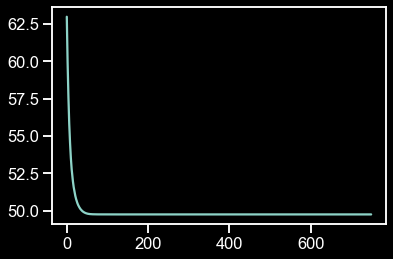

In [29]:
plt.plot(losses)
plt.show()

In [31]:
from curve_fitting import auc_score

scores = R.detach().numpy()

cmp_score_dic = {}

for i, casnumber in enumerate(cids):
    cmp_r_scores = pd.DataFrame(scores[:, :, i], index=F_matrix.columns, columns=np.log10(xs))
    cmp_auc_scores = auc_score(cmp_r_scores)
    cmp_score_dic[casnumber] = (cmp_r_scores, cmp_auc_scores)

In [33]:
d = [cmp_score_dic[cas][1] for cas in cids]

score_frame = pd.DataFrame(d, index=cids)

,ESR1,TP53
8225,9.219,-0.000
9403,8.901,0.000
6291,8.452,-0.000
259331,8.427,0.355
9818306,8.339,0.000
...,...,...
449459,-6.774,0.000
91754,-7.613,-0.000
104741,-7.979,-0.000
154256,-8.931,0.000


In [41]:
score_frame_norm = score_frame.divide(score_frame.max()).fillna(0)

scores_norm = scores.copy()

for r in range(scores_norm.shape[0]):
    scaler = scores[r, :, :].max()
    if scaler != 0:
        scores_norm[r, :, :] = scores_norm[r, :, :]*1/scaler

cmp_score_norm_dic = {}

for i, casnumber in enumerate(cids):
    cmp_r_scores = pd.DataFrame(scores_norm[:, :, i], index=F_matrix.columns, columns=np.log10(xs))
    cmp_score_norm_dic[casnumber] = cmp_r_scores

In [42]:
score_frame_norm.sort_values('ESR1', ascending=False)

,ESR1,TP53
8225,1.000000,-0.000000
9403,0.965506,0.000000
6291,0.916802,-0.000000
259331,0.914090,0.052460
9818306,0.904545,0.000000
...,...,...
449459,-0.734787,0.000000
91754,-0.825795,-0.000000
104741,-0.865495,-0.000000
154256,-0.968760,0.000000


(5064, 2)

In [36]:
ranked = score_frame_norm.sort_values('ESR1', ascending=False)
ranked['ESR1_Rank'] = list(range(1, ranked.shape[0]+1))

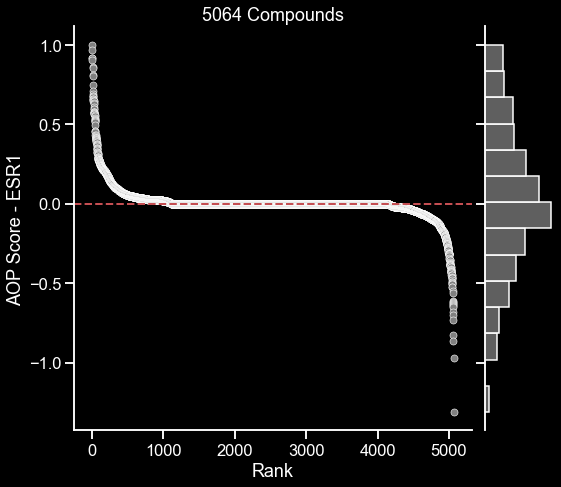

In [76]:

g = sns.jointplot(data=ranked, x='ESR1_Rank', y='ESR1', s=50, color='grey', height=8)

g.ax_joint.axhline(0, ls='--', lw=2, c='r')
g.ax_marg_x.remove()
g.ax_marg_y.set_xscale('log')

g.ax_joint.set_ylabel('AOP Score - ESR1')
g.ax_joint.set_xlabel('Rank')

g.ax_joint.set_title(f'{score_frame_norm.shape[0]} Compounds')

plt.savefig('../data/figures/esr1-rank.png')

In [73]:
ranked2 = score_frame_norm.sort_values('TP53', ascending=False)
ranked2['TP53_Rank'] = list(range(1, ranked2.shape[0]+1))


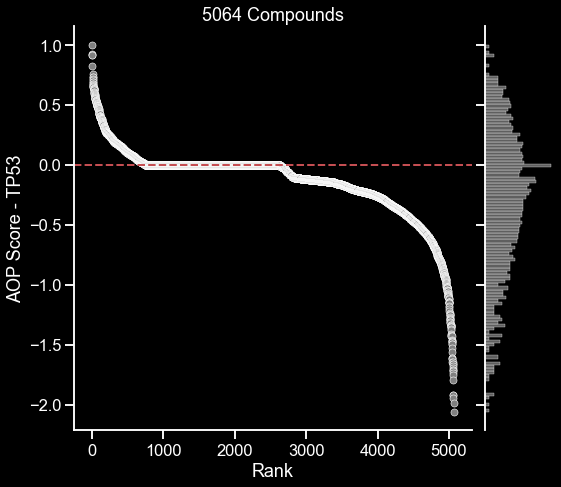

In [75]:
g = sns.jointplot(data=ranked2, x='TP53_Rank', y='TP53', s=50, color='grey', height=8)

g.ax_joint.axhline(0, ls='--', lw=2, c='r')
g.ax_marg_x.remove()
g.ax_marg_y.set_xscale('log')

g.ax_joint.set_ylabel('AOP Score - TP53')
g.ax_joint.set_xlabel('Rank')

g.ax_joint.set_title(f'{score_frame_norm.shape[0]} Compounds')

plt.savefig('../data/figures/TP53-rank.png')

In [137]:
target_cid = ranked2.index[-1]
target_cid

16029989

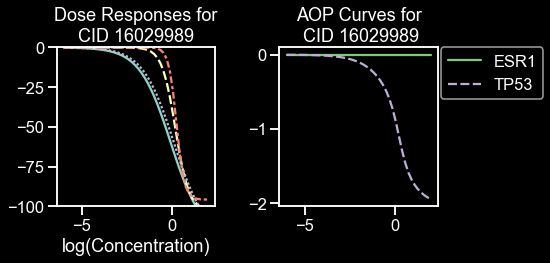

In [138]:
fig, ax = plt.subplots(ncols=2, figsize=plt.figaspect(1/2))


target = TARGETS[1]
data = dfs.query(f'CID == {target_cid} and Target == "{target}"').pivot(columns='log(Concentration)', index='AID', values='Response').T

r = cmp_score_norm_dic[target_cid].T
r.head()

sns.lineplot(data=data, ax=ax[0], legend=False, color='blue')
#ax[0].legend(bbox_to_anchor=(-1.02, 1), loc='upper left', borderaxespad=0)
ax[0].set_title(f"Dose Responses for\nCID {target_cid}")
ax[0].set_ylim(-100, 0)


sns.lineplot(data=r, palette='Accent', ax=ax[1])
ax[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax[1].set_title(f"AOP Curves for\n CID {target_cid}")

plt.tight_layout()
plt.savefig('../data/figures/{}.png'.format(target_cid), transparent=True)

In [122]:
ranked.iloc[-1]

ESR1           -1.311205
TP53           -0.042116
ESR1_Rank    5064.000000
Name: 457193, dtype: float64

In [134]:
data



AID,624305
log(Concentration),
-6.000000,0.498776
-5.571924,0.826381
-5.395833,1.016629
-5.219742,1.250181
-5.043650,1.536645
-4.867559,1.887629
-4.691468,2.317100
-4.515377,2.841760
-4.339285,3.481447


In [140]:
import math
math.log10(10.97)

1.040206627574711

In [ ]:
target_cid

In [ ]:
score_frame_norm.loc[target_cid]

In [ ]:
auc_score(r.T)

In [ ]:
score_frame.max()

In [ ]:
-0.029  * (1 / 14)

In [ ]:
np.sign(r.T.diff(axis=1))

In [ ]:
r.T.sum(axis=1)

In [ ]:
signss = cmp_r_scores.diff(axis=1)
np.sign(cmp_r_scores.sum(1))

In [ ]:
cmp_r_scores.diff(axis=1)

In [ ]:
-1 - 1

In [ ]:
sns.lineplot(data=cmp_r_scores.T)

In [ ]:
sns.lineplot(data=r)